<a href="https://colab.research.google.com/github/ahatesham02/CaptionMetrics/blob/master/Image_Captioning_Memes_Dataset_with_attention_%2B_BiGRU_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
dataset1 = pd.read_excel('/content/drive/MyDrive/Image Caption Generation /Meme Data/multi-sent.xlsx')
dataset1.head(10)

,image_name,Captions,Label_Sentiment
0,tangaila (1).jpg,"আম্মাঃ HSC চলে আসছে , এখন থেকে তোর মোবাইল , ল্...",positive
1,tangaila (2).jpg,WHEN YOUR COUSINS TAKES YOU TO THE DHAN KHET A...,negative
2,tangaila (3).jpg,WHEN HE SAID 10 MINUTES BUT IT WAS ONLY 2 MINUTES,negative
3,tangaila (4).jpg,SHE - I CAN'T BE WITH YOU -তবে শেষবারের মত দ...,negative
4,tangaila (5).jpg,"যখন কোন Teacher বলে ""সত্যটা বলো, তাহলে আর কি...",negative
5,tangaila (6).jpg,আয়মান সাদিক ব্যয়মান সাদিক পরমমান সাদিক ...,negative
6,tangaila (7).jpg,"When your younger brothers asks ""ভাইয়া আমরা ক...",negative
7,tangaila (8).jpg,WHEN YOU ARE ABOUT TO BANG HER & SHE SAYS দাঁড়...,negative
8,tangaila (9).jpg,"BIOLOGY THEORY IS IMPORTANT BUT, BIOLOGY PRACT...",negative
9,tangaila (10).jpg,Nije kono content Create kora Onno ke hoga ...,negative


In [3]:
dataset1.drop(['Label_Sentiment'],axis=1,inplace=True )
dataset1

,image_name,Captions
0,tangaila (1).jpg,"আম্মাঃ HSC চলে আসছে , এখন থেকে তোর মোবাইল , ল্..."
1,tangaila (2).jpg,WHEN YOUR COUSINS TAKES YOU TO THE DHAN KHET A...
2,tangaila (3).jpg,WHEN HE SAID 10 MINUTES BUT IT WAS ONLY 2 MINUTES
3,tangaila (4).jpg,SHE - I CAN'T BE WITH YOU -তবে শেষবারের মত দ...
4,tangaila (5).jpg,"যখন কোন Teacher বলে ""সত্যটা বলো, তাহলে আর কি..."
...,...,...
4363,KAM (791).jpg,আমি ফ্যান নিয়া আসছিলাম আমি টিউবলাইট লইয়া আইছি ...
4364,KAM (792).jpg,এই ইয়ো ইয়ো পানি সিং আমার নাম পানি সিং না.. হান...
4365,KAM (793).jpg,মেনশন করুন আপনার সেই সকল বন্ধু/বান্ধবীদের যারা...
4366,KAM (794).jpg,ইতিহাস সাক্ষী যে স্বামী যত বেশি চুপচাপ এবং মিত...


In [4]:
import zipfile
exfile= '/content/drive/MyDrive/Image Caption Generation /Dataset.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Dataset/Memes'
images = listdir(image_dir)

print("The number of jpg flies in Memes: {}".format(len(images)))

The number of jpg flies in Memes: 4369


In [6]:
def create_vocabulary(data):
  vocab = []
  for captions in dataset1.Captions.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [7]:
vocabulary = create_vocabulary(dataset1)

Vocabulary Size : 17587


In [8]:
import re,nltk,json
from bs4 import BeautifulSoup

In [9]:
'''
Text Cleaning
'''
def text_cleaning(row):
   #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ') 
  post = post.replace('।', ' ')
  text = ''.join([c for c in post if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # # Stopword 
  # result = text.split()
  # text = [word.strip() for word in result if word not in stp ]
  # text =" ".join(text)
  
  return text

In [10]:
dataset1['Captions'] = dataset1.Captions.apply(text_cleaning) 

In [11]:
dataset1.head(10)

,image_name,Captions
0,tangaila (1).jpg,আম্মাঃ hsc চলে আসছে এখন থেকে তোর মোবাইল ল্যাপট...
1,tangaila (2).jpg,when your cousins takes you to the dhan khet a...
2,tangaila (3).jpg,when he said 10 minutes but it was only 2 minutes
3,tangaila (4).jpg,she i cant be with you তবে শেষবারের মত দেখতে দাও
4,tangaila (5).jpg,যখন কোন teacher বলে সত্যটা বলো তাহলে আর কিচ্ছু...
5,tangaila (6).jpg,আয়মান সাদিক ব্যয়মান সাদিক পরমমান সাদিক শতকরামন...
6,tangaila (7).jpg,when your younger brothers asks ভাইয়া আমরা কিভ...
7,tangaila (8).jpg,when you are about to bang her she says দাঁড়াও...
8,tangaila (9).jpg,biology theory is important but biology practi...
9,tangaila (10).jpg,nije kono content create kora onno ke hoga mer...


In [12]:
clean_vocabulary = create_vocabulary(dataset1)

Vocabulary Size : 14190


In [13]:
len(dataset1)

4368

In [14]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in dataset1["image_name"]:
      full_image_path = image_dir+"/"+ filenames
      img_name_vector.append(full_image_path)
  return img_name_vector
img_name_vector = preprocess_images(dataset1)
img_name_vector[:10]

['/content/Dataset/Memes/tangaila (1).jpg',
 '/content/Dataset/Memes/tangaila (2).jpg',
 '/content/Dataset/Memes/tangaila (3).jpg',
 '/content/Dataset/Memes/tangaila (4).jpg',
 '/content/Dataset/Memes/tangaila (5).jpg',
 '/content/Dataset/Memes/tangaila (6).jpg',
 '/content/Dataset/Memes/tangaila (7).jpg',
 '/content/Dataset/Memes/tangaila (8).jpg',
 '/content/Dataset/Memes/tangaila (9).jpg',
 '/content/Dataset/Memes/tangaila (10).jpg']

In [15]:
def preprocess_captions(data):
  total_captions = []

  for caption  in dataset1["Captions"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(dataset1)
total_captions[:10]

['<start> আম্মাঃ hsc চলে আসছে এখন থেকে তোর মোবাইল ল্যাপটপ সব চালানো বন্ধ me মরে যাব রে মরে যাব কি অসহায় আমি একবার ভাব <end>',
 '<start> when your cousins takes you to the dhan khet and shows his kalo bonduk <end>',
 '<start> when he said 10 minutes but it was only 2 minutes <end>',
 '<start> she i cant be with you তবে শেষবারের মত দেখতে দাও <end>',
 '<start> যখন কোন teacher বলে সত্যটা বলো তাহলে আর কিচ্ছু বলবো না ভাইজান আমার কপালে কি বোকাচোদা লেখা আছে <end>',
 '<start> আয়মান সাদিক ব্যয়মান সাদিক পরমমান সাদিক শতকরামন সাদিক <end>',
 '<start> when your younger brothers asks ভাইয়া আমরা কিভাবে হইসি <end>',
 '<start> when you are about to bang her she says দাঁড়াও বাবুকে ঘুম পাড়ায় আসি so you keep waiting like <end>',
 '<start> biology theory is important but biology practical is life me medical এর ভাইয়া biology book <end>',
 '<start> nije kono content create kora onno ke hoga mere famous howa <end>']

In [16]:
print("Total Images : " + str(len(img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 4368
Total Captions : 4368


In [17]:
from pickle import load,dump

In [18]:
# save to file
dump(total_captions, open('/content/drive/MyDrive/Image Caption Generation /Meme Data/memes_captions.pkl', 'wb'))
dump(img_name_vector, open('/content/drive/MyDrive/Image Caption Generation /Meme Data/memes_img_names.pkl', 'wb'))

In [19]:
train_captions = load(open('/content/drive/MyDrive/Image Caption Generation /Meme Data/memes_captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/Image Caption Generation /Meme Data/memes_img_names.pkl', 'rb'))

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [21]:
preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [22]:
for img in img_name_vector[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize : (224, 224, 3)


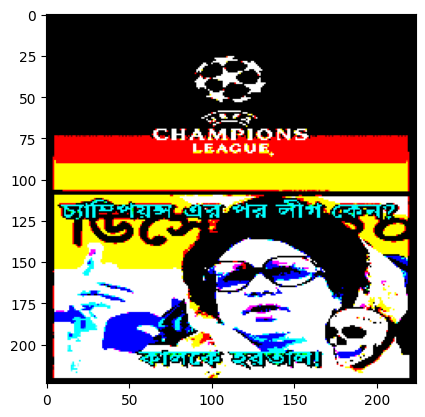

In [23]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("/content/Dataset/Memes/KAM (103).png")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

## Load Pretrained Model

In [24]:
image_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

94765736/94765736 [==============================] - 4s 0us/step


In [25]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

## Tokenizer and Vocabulary

In [26]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [27]:
vocab_size = len(tokenizer.index_word)+1

In [28]:
vocab_size

14195

In [29]:
train_captions[:3]

['<start> আম্মাঃ hsc চলে আসছে এখন থেকে তোর মোবাইল ল্যাপটপ সব চালানো বন্ধ me মরে যাব রে মরে যাব কি অসহায় আমি একবার ভাব <end>',
 '<start> when your cousins takes you to the dhan khet and shows his kalo bonduk <end>',
 '<start> when he said 10 minutes but it was only 2 minutes <end>']

In [30]:
train_seqs[:3]

[[2,
  1,
  849,
  113,
  500,
  55,
  22,
  29,
  227,
  3746,
  54,
  1810,
  122,
  15,
  664,
  582,
  135,
  664,
  582,
  7,
  2755,
  5,
  400,
  721,
  3],
 [2, 23, 78, 2756, 2168, 12, 37, 34, 1, 1, 76, 1, 420, 1, 1, 3],
 [2, 23, 248, 1517, 526, 1811, 170, 249, 583, 928, 584, 1811, 3]]

In [31]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'না',
 5: 'আমি',
 6: 'আমার',
 7: 'কি',
 8: 'যখন',
 9: 'আর',
 10: 'করে',
 11: 'তো',
 12: 'you',
 13: 'এর',
 14: 'পর',
 15: 'me',
 16: 'তুমি',
 17: 'হয়',
 18: 'তোমার',
 19: 'কেন',
 20: 'একটা',
 21: 'সাথে',
 22: 'থেকে',
 23: 'when',
 24: 'a',
 25: 'জন্য',
 26: 'এই',
 27: 'কিন্তু',
 28: 'হবে',
 29: 'তোর',
 30: 'যায়',
 31: 'করতে',
 32: 'বলে',
 33: 'দিয়ে',
 34: 'the',
 35: 'যে',
 36: 'এ',
 37: 'to',
 38: 'হয়ে',
 39: 'আছে',
 40: 'ভাই',
 41: 'কোন',
 42: 'মেয়ে',
 43: 'নাই',
 44: 'তুই',
 45: 'কে',
 46: 'আগে',
 47: 'নিয়ে',
 48: 'টাকা',
 49: 'আমাকে',
 50: 'ছেলে',
 51: 'করা',
 52: 'টা',
 53: 'ও',
 54: 'সব',
 55: 'এখন',
 56: 'কথা',
 57: 'i',
 58: 'in',
 59: 'কিছু',
 60: 'my',
 61: 'মনে',
 62: 'করার',
 63: 'আপনার',
 64: 'আমাদের',
 65: 'of',
 66: 'আমিঃ',
 67: 'বড়',
 68: 'স্যার',
 69: 'কী',
 70: 'সময়',
 71: 'ভালো',
 72: 'আমরা',
 73: 'দেয়',
 74: 'এক',
 75: 'করি',
 76: 'and',
 77: 'দিন',
 78: 'your',
 79: 'বিয়ে',
 80: 'অনেক',
 81: 'কেউ',
 82: 'নাকি',
 83: 'is'

In [32]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(4368, 108)


In [33]:
cap_vector

array([[   2,    1,  849, ...,    0,    0,    0],
       [   2,   23,   78, ...,    0,    0,    0],
       [   2,   23,  248, ...,    0,    0,    0],
       ...,
       [   2, 2055,  893, ...,    0,    0,    0],
       [   2, 3606, 3731, ...,    0,    0,    0],
       [   2,    1, 4580, ...,    0,    0,    0]], dtype=int32)

## Creating Dataset

In [34]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [35]:
path_train, path_test, caption_train, caption_test = train_test_split(img_name_vector, cap_vector, test_size = 0.1, random_state = 42)

In [36]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 3931
Testing data for images: 437
Training data for Captions: 3931
Testing data for Captions: 437


In [37]:
from tqdm import tqdm

In [38]:
New_Img

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [39]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 69/69 [00:40<00:00,  1.68it/s]


In [40]:
batch_features

<tf.Tensor: shape=(16, 7, 7, 2048), dtype=float32, numpy=
array([[[[2.24065518e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.71162796e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 5.54541206e+00, ...,
          2.43297887e+00, 1.61164594e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 2.11759877e+00, ...,
          1.72613287e+00, 1.56016397e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.92054045e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 6.59386516e-01, 0.00000000e+00, ...,
         

In [41]:
batch_features_flattened

<tf.Tensor: shape=(16, 49, 2048), dtype=float32, numpy=
array([[[ 2.2406552 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.711628  ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.44242966,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.30238456,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  3.9399736 ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  5.8085513 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...

In [42]:
batch_feat.shape

TensorShape([49, 2048])

In [43]:
img_features 

{'/content/Dataset/Memes/Bangla Thug Life (1).jpg': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [3.0766296, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '/content/Dataset/Memes/Bangla Thug Life (10).jpg': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        

In [44]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [45]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [46]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [47]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 108)


In [69]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE 
EPOCHS = 20
max_length = 108
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [70]:
vocab_size

14195

In [71]:
feature_shape

2048

In [72]:
attention_feature_shape

49

## CNN Encoder

In [73]:
from keras.utils.vis_utils import plot_model

In [74]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [75]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [76]:
encoder=Encoder(embedding_dim)

## Attention Model

In [77]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

## Decoder

In [78]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state,_ = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [79]:
class Decoder2(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder2, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state_f,state_b = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print(output.shape)
        #print(state_f.shape)
        #print(state_b.shape)
        state = tf.keras.layers.Add()([state_f, state_b])
        #print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [80]:
decoder=Decoder2(embedding_dim, units, vocab_size)

In [81]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 14195)
Attention weights shape from Decoder: (64, 49, 1)


In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [83]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [84]:
checkpoint_path = "/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [85]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [86]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [87]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [88]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [89]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.007, & test loss is 1.092
Time taken for 1 epoch 671.2741215229034 sec

Test loss has been reduced from 100.000 to 1.092


  3%|▎         | 1/30 [11:12<5:24:48, 672.01s/it]

For epoch: 2, the train loss is 0.936, & test loss is 1.045
Time taken for 1 epoch 36.296103954315186 sec

Test loss has been reduced from 1.092 to 1.045


  7%|▋         | 2/30 [11:49<2:19:21, 298.64s/it]

For epoch: 3, the train loss is 0.906, & test loss is 1.006
Time taken for 1 epoch 35.33066391944885 sec

Test loss has been reduced from 1.045 to 1.006


 10%|█         | 3/30 [12:25<1:20:24, 178.69s/it]

For epoch: 4, the train loss is 0.868, & test loss is 0.953
Time taken for 1 epoch 34.4777569770813 sec

Test loss has been reduced from 1.006 to 0.953


 13%|█▎        | 4/30 [13:00<52:54, 122.11s/it]  

For epoch: 5, the train loss is 0.826, & test loss is 0.914
Time taken for 1 epoch 34.052417278289795 sec

Test loss has been reduced from 0.953 to 0.914


 17%|█▋        | 5/30 [13:35<37:45, 90.63s/it] 

For epoch: 6, the train loss is 0.797, & test loss is 0.881
Time taken for 1 epoch 33.24787354469299 sec

Test loss has been reduced from 0.914 to 0.881


 20%|██        | 6/30 [14:09<28:32, 71.33s/it]

For epoch: 7, the train loss is 0.763, & test loss is 0.841
Time taken for 1 epoch 33.13983654975891 sec

Test loss has been reduced from 0.881 to 0.841


 23%|██▎       | 7/30 [14:43<22:40, 59.15s/it]

For epoch: 8, the train loss is 0.730, & test loss is 0.798
Time taken for 1 epoch 32.76398491859436 sec

Test loss has been reduced from 0.841 to 0.798


 27%|██▋       | 8/30 [15:16<18:42, 51.01s/it]

For epoch: 9, the train loss is 0.689, & test loss is 0.747
Time taken for 1 epoch 32.71791195869446 sec

Test loss has been reduced from 0.798 to 0.747


 30%|███       | 9/30 [15:50<15:57, 45.59s/it]

For epoch: 10, the train loss is 0.646, & test loss is 0.694
Time taken for 1 epoch 32.89256763458252 sec

Test loss has been reduced from 0.747 to 0.694


 33%|███▎      | 10/30 [16:24<13:57, 41.88s/it]

For epoch: 11, the train loss is 0.600, & test loss is 0.641
Time taken for 1 epoch 32.68278908729553 sec

Test loss has been reduced from 0.694 to 0.641


 37%|███▋      | 11/30 [16:57<12:27, 39.35s/it]

For epoch: 12, the train loss is 0.550, & test loss is 0.577
Time taken for 1 epoch 32.81468462944031 sec

Test loss has been reduced from 0.641 to 0.577


 40%|████      | 12/30 [17:31<11:15, 37.55s/it]

For epoch: 13, the train loss is 0.501, & test loss is 0.525
Time taken for 1 epoch 33.17086124420166 sec

Test loss has been reduced from 0.577 to 0.525


 43%|████▎     | 13/30 [18:05<10:20, 36.51s/it]

For epoch: 14, the train loss is 0.456, & test loss is 0.476
Time taken for 1 epoch 32.72029089927673 sec

Test loss has been reduced from 0.525 to 0.476


 47%|████▋     | 14/30 [18:38<09:29, 35.58s/it]

For epoch: 15, the train loss is 0.412, & test loss is 0.431
Time taken for 1 epoch 32.54719138145447 sec

Test loss has been reduced from 0.476 to 0.431


 50%|█████     | 15/30 [19:12<08:43, 34.92s/it]

For epoch: 16, the train loss is 0.373, & test loss is 0.386
Time taken for 1 epoch 32.464144706726074 sec

Test loss has been reduced from 0.431 to 0.386


 53%|█████▎    | 16/30 [19:45<08:01, 34.41s/it]

For epoch: 17, the train loss is 0.336, & test loss is 0.341
Time taken for 1 epoch 32.52921199798584 sec

Test loss has been reduced from 0.386 to 0.341


 57%|█████▋    | 17/30 [20:18<07:23, 34.11s/it]

For epoch: 18, the train loss is 0.299, & test loss is 0.307
Time taken for 1 epoch 32.332926988601685 sec

Test loss has been reduced from 0.341 to 0.307


 60%|██████    | 18/30 [20:51<06:45, 33.80s/it]

For epoch: 19, the train loss is 0.269, & test loss is 0.279
Time taken for 1 epoch 32.67681336402893 sec

Test loss has been reduced from 0.307 to 0.279


 63%|██████▎   | 19/30 [21:25<06:10, 33.72s/it]

For epoch: 20, the train loss is 0.243, & test loss is 0.247
Time taken for 1 epoch 32.47487258911133 sec

Test loss has been reduced from 0.279 to 0.247


 67%|██████▋   | 20/30 [21:58<05:35, 33.54s/it]

For epoch: 21, the train loss is 0.217, & test loss is 0.221
Time taken for 1 epoch 33.03722429275513 sec

Test loss has been reduced from 0.247 to 0.221


 70%|███████   | 21/30 [22:32<05:02, 33.66s/it]

For epoch: 22, the train loss is 0.193, & test loss is 0.199
Time taken for 1 epoch 32.306230783462524 sec

Test loss has been reduced from 0.221 to 0.199


 73%|███████▎  | 22/30 [23:05<04:27, 33.46s/it]

For epoch: 23, the train loss is 0.174, & test loss is 0.180
Time taken for 1 epoch 32.51106095314026 sec

Test loss has been reduced from 0.199 to 0.180


 77%|███████▋  | 23/30 [23:38<03:54, 33.44s/it]

For epoch: 24, the train loss is 0.156, & test loss is 0.156
Time taken for 1 epoch 32.69119429588318 sec

Test loss has been reduced from 0.180 to 0.156


 80%|████████  | 24/30 [24:12<03:20, 33.49s/it]

For epoch: 25, the train loss is 0.140, & test loss is 0.143
Time taken for 1 epoch 32.506062507629395 sec

Test loss has been reduced from 0.156 to 0.143


 83%|████████▎ | 25/30 [24:45<02:47, 33.47s/it]

For epoch: 26, the train loss is 0.125, & test loss is 0.129
Time taken for 1 epoch 32.50118160247803 sec

Test loss has been reduced from 0.143 to 0.129


 87%|████████▋ | 26/30 [25:19<02:13, 33.38s/it]

For epoch: 27, the train loss is 0.113, & test loss is 0.117
Time taken for 1 epoch 32.17042779922485 sec

Test loss has been reduced from 0.129 to 0.117


 90%|█████████ | 27/30 [25:52<01:39, 33.27s/it]

For epoch: 28, the train loss is 0.100, & test loss is 0.104
Time taken for 1 epoch 32.05963921546936 sec

Test loss has been reduced from 0.117 to 0.104


 93%|█████████▎| 28/30 [26:24<01:06, 33.13s/it]

For epoch: 29, the train loss is 0.092, & test loss is 0.097
Time taken for 1 epoch 32.60852241516113 sec

Test loss has been reduced from 0.104 to 0.097


 97%|█████████▋| 29/30 [26:58<00:33, 33.25s/it]

For epoch: 30, the train loss is 0.083, & test loss is 0.086
Time taken for 1 epoch 32.32017159461975 sec

Test loss has been reduced from 0.097 to 0.086


100%|██████████| 30/30 [27:31<00:00, 55.05s/it]


In [90]:
ckpt_manager.checkpoints

['/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-26',
 '/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-27',
 '/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-28',
 '/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-29',
 '/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-30']

In [92]:
ckpt.restore('/content/drive/MyDrive/Image Caption Generation /Meme Data/Models attention_bigru/ckpt-30')

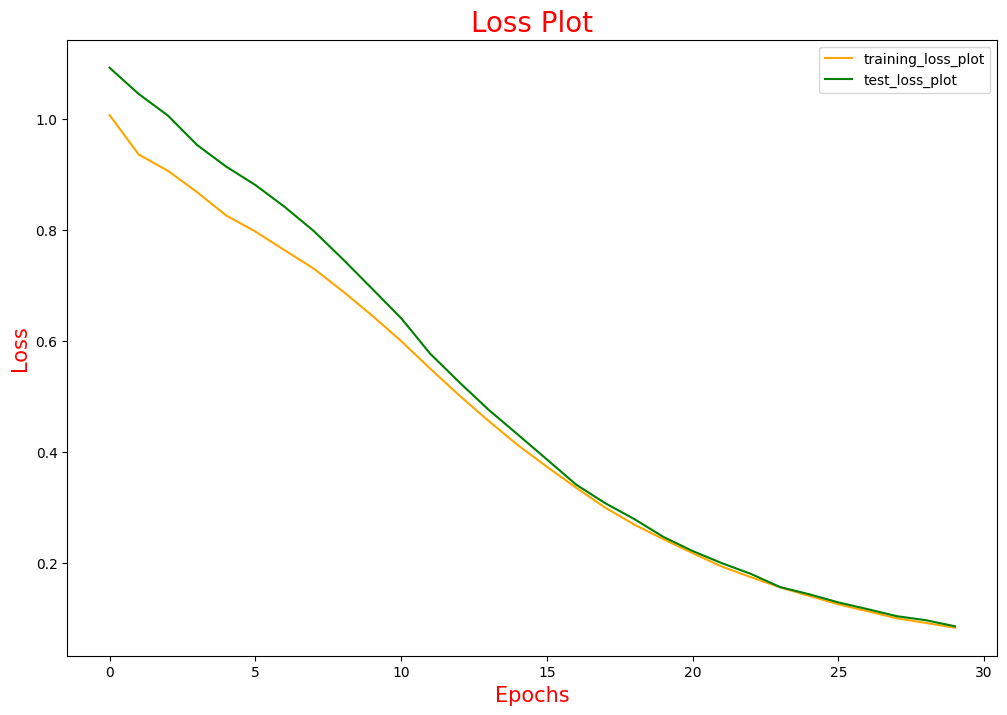

In [93]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [ ]:
attention_feature_shape

In [94]:
attention_plot = np.zeros((max_length, attention_feature_shape))
attention_plot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
font_path = '/content/drive/MyDrive/Image Caption Generation /Meme Data/SolaimanLipi_20-04-07.ttf'
prop = fm.FontProperties(fname=font_path)

In [96]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [97]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (12, 12))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap],fontsize = 18, color = 'red',fontproperties=prop)

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [98]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [99]:
image_test = path_test.copy()

In [100]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [101]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [102]:
from nltk.translate.meteor_score import meteor_score

In [ ]:
encoder.save_weights('content/outputs_encoder')
decoder.save_weights('.content/outputs_decoder')

In [ ]:
path_test

BLEU-1: 62.500000
BLEU-2: 42.257713
BLEU-3: 16.323838
BLEU-4: 10.650955
Meteor Score: 0.841509
Real Caption: in the vs grameenphone now
Prediction Caption: <unk> in the <unk> vs grameenphone <unk> now


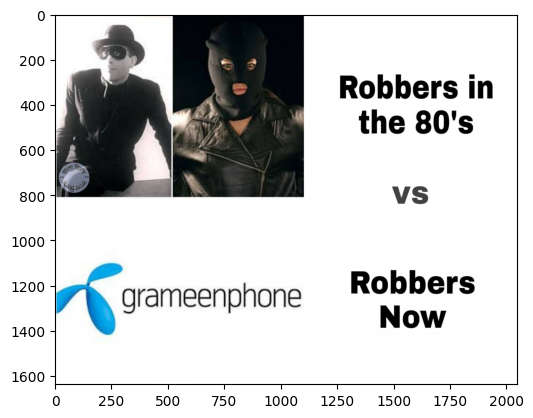

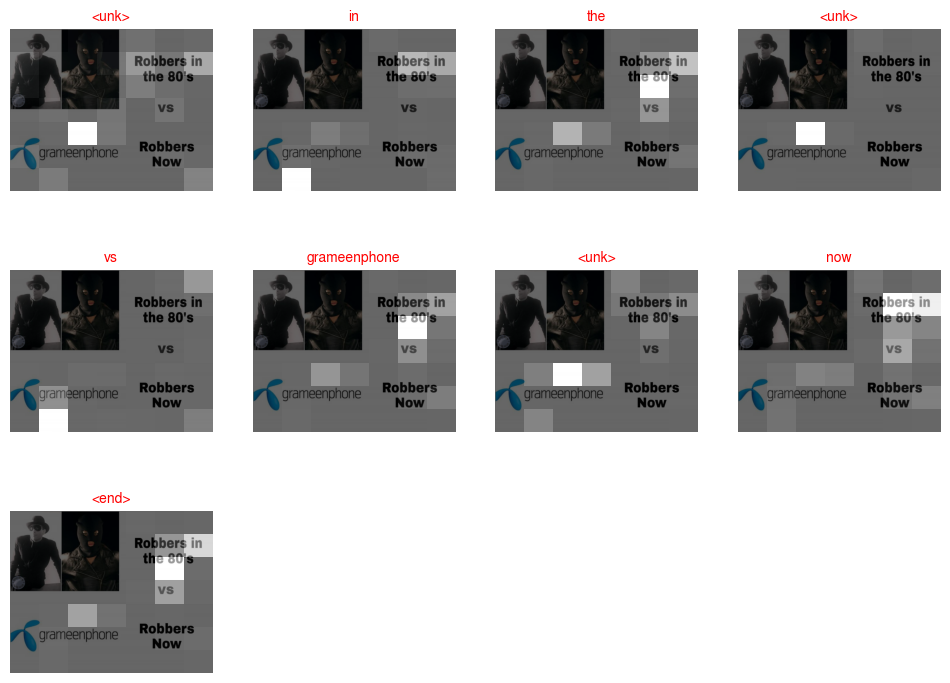

In [107]:
cap_test_data = caption_test.copy()
rid = 34

test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
temp_img = np.array(Image.open(test_image))
plt.imshow(temp_img)
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('Meteor Score: %f' % score)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

plot_attention_map(result, attention_plot, test_image)


In [108]:

b1=[]
b2=[]
b3=[]
b4=[]
m_score=[]

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  print(pred_caption)
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

elder siblings তুই এতিম তোরে আমরা রাস্তায় পাইছি তোর মার নাম <unk> 8 years old me
<unk> বসে থাকার পর যখন পাদ আসে
<unk> তো অন্যরকম টেস্ট লাগতাছে রান্না করতে গিয়ে পুড়ে গেছিলো তাই <unk> ক্রিম লাগাই দিছি
নোবেল বাংলাদেশ থেকে এসে ভারতে গান করার সুযোগ পেয়েছে একটু <unk> তুলে ধরে না এবার <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে <unk> ওকে
যখন প্রথমবার <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> hai <unk> <unk> ha

In [109]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

BLEU-1: 56.415049
BLEU-2: 52.187910
BLEU-3: 46.675685
BLEU-4: 43.208954


In [110]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

Meteor Score of Bahdanau attention: 0.690264
